# E02. Evaluate Players
This evaluates player projections
- Type: Evaluation
- Run Frequency: Irregular
- Sources:
    - Daily Fantasy Fuel
    - Player Results (MLB API)
- Dates:
    - Created: 3/30/2024
    - Updated: 5/5/2024

In [1]:
%run "C:\Users\james\Documents\MLB\Code\U1. Imports.ipynb"
%run "C:\Users\james\Documents\MLB\Code\U2. Utilities.ipynb"
%run "C:\Users\james\Documents\MLB\Code\U3. Classes.ipynb"

### Goals:
- Compare my FP projections to actual FP scored
    - Main breakdowns
        - Batters
            - Overall
            - Lefty*
            - Righty*
            - Unimputed
            - Imputed
            - Unsubbed
        - Pitchers (SP only)
            - Overall
            - Lefty*
            - Righty*
            - Unimputed
            - Imputed
    - By projection quantile
        - Batters
        - Pitchers (SP only)
    - By park
        - Batters
        - Pitchers (SP only)
    - By year
        - Batters
        - Pitchers (SP only)

- Compare my scoring component projections to actual scoring component scoring (projected singles vs. actual singles, etc...) (mean)
    - Batters
    - Pitchers (SP only)
    
- Compare my FP projections to other FP projections (mean, MSE)
    - Batters
    - Pitchers (SP only)

### Dates

In [2]:
start_date = "20240101"
# end_date = yesterdaysdate
end_date = "20240930"

# start_date = todaysdate
# end_date = todaysdate

### Games

Games played

In [3]:
%%time
historic_game_df = pd.read_csv(os.path.join(baseball_path, "game_df.csv"))
recent_game_df = create_games(yesterdaysdate, todaysdate, team_dict)
historic_game_df = historic_game_df[~historic_game_df['date'].astype(str).isin([yesterdaysdate, todaysdate])]
all_game_df = pd.concat([historic_game_df, recent_game_df], axis=0)
all_game_df.to_csv(os.path.join(baseball_path, "game_df.csv"), index=False)

CPU times: total: 203 ms
Wall time: 384 ms


In [4]:
game_df = all_game_df[(all_game_df['date'].astype(str) >= start_date) & (all_game_df['date'].astype(str) <= end_date)].reset_index(drop=True)

Dates and games with my projections

In [5]:
date_mask = (game_df['date'].astype(str) >= start_date) & (game_df['date'].astype(str) <= end_date) 
date_list = list(game_df[date_mask]['date'].unique())
date_folders = [f"Matchups {date}" for date in date_list]
date_folders = [date_folder for date_folder in os.listdir(r"C:\Users\james\Documents\MLB\Database\B02. Simulations\2. Player Sims") and date_folders]

game_list = list(game_df[date_mask]['game_id'].unique())
player_folders = [f"Players {game}" for game in game_list]

### Functions

Extract date, teams, and gamePk from folder names

In [6]:
def extract_info_from_folder(date_folder, matchup_folder):
    # Extract date from date folder
    date = date_folder.split(' ')[1]
    
    # Extract teams and gamePK from matchup folder
    parts = matchup_folder.split(' ')
    away_team, home_team = parts[0].split('@')
    gamePk = parts[1]
    
    return date, away_team, home_team, gamePk

Average player stats for a given position group

In [7]:
def game_averages(date_folder, matchup_folder, position='pitchers'):
    date, away_team, home_team, gamePk = extract_info_from_folder(date_folder, matchup_folder)
    
    # Initialize an empty list to store DataFrames
    dfs = []
    
    # Get a list of all CSV files in the matchup folder
    csv_files = [file for file in os.listdir(os.path.join(baseball_path, "B02. Simulations", "2. Player Sims", date_folder, matchup_folder)) 
                 if file.startswith(position) and file.endswith('.csv')]
    
    # Iterate over each CSV file
    for csv_file in csv_files:
        # Read the CSV file into a DataFrame
        df = pd.read_csv(os.path.join(baseball_path, "B02. Simulations", "2. Player Sims", date_folder, matchup_folder, csv_file))
        
        # Append date, away_team, home_team, and gamePk columns
        df['date'] = date
        df['away_team'] = away_team
        df['home_team'] = home_team
        df['gamePk'] = gamePk
        
        # Append the DataFrame to the list
        dfs.append(df)
    
    # Concatenate all DataFrames in the list
    combined_df = pd.concat(dfs)
    
    # Select numeric columns
    numeric_cols = combined_df.select_dtypes(include='number')
    
    # Group by fullName and calculate the mean for numeric columns
    averaged_numeric_cols = numeric_cols.groupby(combined_df['fullName'], sort=False).mean()
    
    # Select team and additional columns
    additional_cols = combined_df[['fullName', 'team', 'date', 'away_team', 'home_team', 'gamePk']].drop_duplicates('fullName').set_index('fullName')
    
    # Concatenate numeric and additional columns
    averaged_df = pd.concat([additional_cols, averaged_numeric_cols], axis=1).reset_index()

    averaged_df['team_abbrev'] = np.where(averaged_df['team'] == "away", averaged_df['away_team'], averaged_df['home_team'])

    averaged_df['starter'] = (~averaged_df['team'].duplicated()).astype(int)

    return averaged_df

### Player Sim Files

Calculate averages for player stats in simulations by game

##### Batters

Calculate averages

In [8]:
%%time
position = 'batters'

# Parallelize the loop using joblib and directly return df_list
batter_df_list = Parallel(n_jobs=-1)(
    delayed(game_averages)(date_folder, matchup_folder, position) 
    for date_folder in date_folders 
    for matchup_folder in os.listdir(os.path.join(baseball_path, "B02. Simulations", "2. Player Sims", date_folder)))

CPU times: total: 6.14 s
Wall time: 8.05 s


Write to CSV

In [9]:
for df in batter_df_list:
    gamePk = df['gamePk'][0]
    away_df = df.query('team == "away"')
    home_df = df.query('team == "home"')
    
    # Create folder
    os.makedirs(os.path.join(baseball_path, "C04. Players", f"Players {gamePk}"), exist_ok=True)

    # Write to csv
    away_df.to_csv(os.path.join(baseball_path, "C04. Players", f"Players {gamePk}", f"away batters projections {gamePk}.csv"), index=False)
    home_df.to_csv(os.path.join(baseball_path, "C04. Players", f"Players {gamePk}", f"home batters projections {gamePk}.csv"), index=False)

##### Pitchers

Calculate averages

In [10]:
%%time
position = 'pitchers'

# Parallelize the loop using joblib and directly return df_list
pitcher_df_list = Parallel(n_jobs=-1)(
    delayed(game_averages)(date_folder, matchup_folder, position) 
    for date_folder in date_folders 
    for matchup_folder in os.listdir(os.path.join(baseball_path, "B02. Simulations", "2. Player Sims", date_folder)))

CPU times: total: 4.08 s
Wall time: 4.48 s


Write to CSV

In [11]:
for df in pitcher_df_list:
    gamePk = df['gamePk'][0]
    away_df = df.query('team == "away"')
    home_df = df.query('team == "home"')
    
    # Create folder
    os.makedirs(os.path.join(baseball_path, "C04. Players", f"Players {gamePk}"), exist_ok=True)

    # Write to csv
    away_df.to_csv(os.path.join(baseball_path, "C04. Players", f"Players {gamePk}", f"away pitchers projections {gamePk}.csv"), index=False)
    home_df.to_csv(os.path.join(baseball_path, "C04. Players", f"Players {gamePk}", f"home pitchers projections {gamePk}.csv"), index=False)

### Player Scoring

Add players' actual scoring onto simulated projections

##### Batters

In [12]:
# Define a function to process each folder
def process_batters(folder):
    # Extract gamePk
    gamePk = folder.split(" ")[1]

    ### Batters
    ## Away
    # Read in projections
    away_batter_projected_results_df = pd.read_csv(os.path.join(baseball_path, "C04. Players", f"Players {gamePk}", f"away batters projections {gamePk}.csv"))
    # Read in results
    away_batter_actual_results_df = pd.read_csv(os.path.join(baseball_path, "A10. Player Results", f"Player Results {gamePk}", f"away batters {gamePk}.csv"))

    # Merge
    away_batters_merged = away_batter_projected_results_df[['fullName', 'id', 'imp_b_l', 'imp_b_r', 'PA', 'HBP', 'BB', 'B1', 'B2', 'B3', 'HR', 'SB', 'R', 'RBI', 'FP', 'gamePk']].merge(away_batter_actual_results_df, left_on=['id', 'gamePk'], right_on=['personId', 'gamePk'], how='outer')

    ## Home
    # Read in projections
    home_batter_projected_results_df = pd.read_csv(os.path.join(baseball_path, "C04. Players", f"Players {gamePk}", f"home batters projections {gamePk}.csv"))
    # Read in results
    home_batter_actual_results_df = pd.read_csv(os.path.join(baseball_path, "A10. Player Results", f"Player Results {gamePk}", f"home batters {gamePk}.csv"))

    # Merge
    home_batters_merged = home_batter_projected_results_df[['fullName', 'id', 'imp_b_l', 'imp_b_r', 'PA', 'HBP', 'BB', 'B1', 'B2', 'B3', 'HR', 'SB', 'R', 'RBI', 'FP', 'gamePk']].merge(home_batter_actual_results_df, left_on=['id', 'gamePk'], right_on=['personId', 'gamePk'], how='outer')

    # Append them together
    batters_merged = pd.concat([away_batters_merged, home_batters_merged], axis=0)

    
    return batters_merged

In [13]:
def process_batters2(folder):
    try:
        batters_merged = process_batters(folder)    
        return batters_merged   
    except:
        pass 

In [14]:
%%time
# Run the loop in parallel
batters_merged_list = Parallel(n_jobs=-1)(delayed(process_batters2)(folder) for folder in player_folders)
batters_merged_df = pd.concat(batters_merged_list, axis=0)

CPU times: total: 5.64 s
Wall time: 11.4 s


##### Pitchers

In [15]:
def process_pitchers(folder):
    # Extract gamePk
    gamePk = folder.split(" ")[1]
    
    ### Pitchers
    ## Away
    # Read in projections
    away_pitcher_projected_results_df = pd.read_csv(os.path.join(baseball_path, "C04. Players", f"Players {gamePk}", f"away pitchers projections {gamePk}.csv"))
    away_pitcher_projected_results_df['team'] = "away"
    # Read in results
    away_pitcher_actual_results_df = pd.read_csv(os.path.join(baseball_path, "A10. Player Results", f"Player Results {gamePk}", f"away pitchers {gamePk}.csv"))

    # Merge
    away_pitchers_merged = away_pitcher_projected_results_df[['fullName', 'id', 'imp_p_l', 'imp_p_r', 'OUT', 'PA', 'SO', 'HBP', 'BB', 'B1', 'B2', 'B3', 'HR', 'H', 'R', 'ER', 'W', 'CG', 'CGSO', 'NH', 'FP', 'team', 'gamePk']].merge(away_pitcher_actual_results_df, left_on=['id', 'gamePk', 'team'], right_on=['personId', 'gamePk', 'team'], how='outer')
    
    ## Home
    # Read in projections
    home_pitcher_projected_results_df = pd.read_csv(os.path.join(baseball_path, "C04. Players", f"Players {gamePk}", f"home pitchers projections {gamePk}.csv"))
    home_pitcher_projected_results_df['team'] = "home"
    # Read in results
    home_pitcher_actual_results_df = pd.read_csv(os.path.join(baseball_path, "A10. Player Results", f"Player Results {gamePk}", f"home pitchers {gamePk}.csv"))

    # Merge
    home_pitchers_merged = home_pitcher_projected_results_df[['fullName', 'id', 'imp_p_l', 'imp_p_r', 'OUT', 'PA', 'SO', 'HBP', 'BB', 'B1', 'B2', 'B3', 'HR', 'H', 'R', 'ER', 'W', 'CG', 'CGSO', 'NH', 'FP', 'team', 'gamePk']].merge(home_pitcher_actual_results_df, left_on=['id', 'gamePk', 'team'], right_on=['personId', 'gamePk', 'team'], how='outer')

    # Append them together
    pitchers_merged = pd.concat([away_pitchers_merged, home_pitchers_merged], axis=0)

    
    return pitchers_merged

In [16]:
def process_pitchers2(folder):
    try:
        pitchers_merged = process_pitchers(folder)    
        return pitchers_merged   
    except:
        pass 

In [17]:
%%time
# Run the loop in parallel
pitchers_merged_list = Parallel(n_jobs=-1)(delayed(process_pitchers2)(folder) for folder in player_folders)
pitchers_merged_df = pd.concat(pitchers_merged_list, axis=0)

CPU times: total: 6.25 s
Wall time: 13.2 s


### 1. Player Stat Evaluations

File path

In [18]:
player_stat_path = os.path.join(baseball_path, "C02. Players", "1. Player Stat Evaluations", f"Player Stat Evaluations {todaysdate}.xlsx")

##### Batters

Create New Variables

In [19]:
# Actual singles
batters_merged_df['singles'] = batters_merged_df['h'] - batters_merged_df['doubles'] - batters_merged_df['triples'] - batters_merged_df['hr']
# Actual PA
batters_merged_df['pa'] = batters_merged_df[['ab', 'bb', 'hbp']].sum(axis=1)
# Projected hits
batters_merged_df['H'] = batters_merged_df[['B1', 'B2', 'B3', 'HR']].sum(axis=1)
# Reached
batters_merged_df['ON'] = batters_merged_df[['H', 'BB', 'HBP']].sum(axis=1)
batters_merged_df['on'] = batters_merged_df[['h', 'bb', 'hbp']].sum(axis=1)

In [20]:
# Identify number of batters that batted in a given spot in the order (we may only want those who were never subbed out or are subs)
batters_merged_df['battingSpot'] = batters_merged_df['battingOrder'] // 100
# Instance of batter in that spot
# Example:
# Three batters batted 4
# All three would have battingSpot = 4
# battingSpotInstance for starter would be 1, the first sub would be 2, second sub would be 3
batters_merged_df['battingSpotInstance'] = batters_merged_df.groupby(['gamePk', 'team', 'battingSpot'])['battingSpot'].transform('count')

##### Figure 1A. Unimputed Starting Batters

In [21]:
unimputed_batters = batters_merged_df.query('battingSpotInstance == 1').query('imp_b_l == 0 & imp_b_r == 0')[['PA', 'pa', 'ON', 'on', 'H', 'h', 'B1', 'singles', 'B2', 'doubles', 'B3', 'triples', 'HR', 'hr', 'BB', 'bb', 'SB', 'sb', 'FP', 'fp']].agg(['mean', 'sum'])

# Split the dataframe into projected (even rows) and actual (odd rows)
projected = unimputed_batters.T.iloc[::2].reset_index()
actual = unimputed_batters.T.iloc[1::2].reset_index()

# Concatenate the two dataframes side-by-side
unimputed_batters = pd.concat([projected, actual], axis=1)

# Rename the columns
unimputed_batters.columns = ["Projected", "Projected Mean", 'Projected Sum', "Actual", "Actual Mean", 'Actual Sum']

# Set Projected Share
unimputed_batters['Projected Share'] = 0.0
unimputed_batters.loc[unimputed_batters['Projected'] == 'PA', 'Projected Share'] = 1
unimputed_batters.loc[unimputed_batters['Projected'] == 'ON', 'Projected Share'] = (
    unimputed_batters.loc[unimputed_batters['Projected'] == 'ON', 'Projected Mean'].values[0] /
    unimputed_batters.loc[unimputed_batters['Projected'] == 'PA', 'Projected Mean'].values[0]
)
unimputed_batters.loc[~unimputed_batters['Projected'].isin(['PA', 'ON']), 'Projected Share'] = (
    unimputed_batters.loc[~unimputed_batters['Projected'].isin(['PA', 'ON']), 'Projected Mean'] /
    unimputed_batters.loc[unimputed_batters['Projected'] == 'ON', 'Projected Mean'].values[0]
)

# Set Actual Share
unimputed_batters['Actual Share'] = 0.0
unimputed_batters.loc[unimputed_batters['Actual'] == 'pa', 'Actual Share'] = 1
unimputed_batters.loc[unimputed_batters['Actual'] == 'on', 'Actual Share'] = (
    unimputed_batters.loc[unimputed_batters['Actual'] == 'on', 'Actual Mean'].values[0] /
    unimputed_batters.loc[unimputed_batters['Actual'] == 'pa', 'Actual Mean'].values[0]
)
unimputed_batters.loc[~unimputed_batters['Actual'].isin(['pa', 'on']), 'Actual Share'] = (
    unimputed_batters.loc[~unimputed_batters['Actual'].isin(['pa', 'on']), 'Actual Mean'] /
    unimputed_batters.loc[unimputed_batters['Actual'] == 'on', 'Actual Mean'].values[0]
)

# Rename
unimputed_batters.rename(columns={'Projected': 'Stat'}, inplace=True)

# Cut
unimputed_batters = unimputed_batters[['Stat', 'Projected Mean', 'Actual Mean', 'Projected Share', 'Actual Share']].round(4)
unimputed_batters

,Stat,Projected Mean,Actual Mean,Projected Share,Actual Share
0,PA,4.2381,4.1408,1.0000,1.0000
1,ON,1.3491,1.3048,0.3183,0.3151
2,H,0.9369,0.9219,0.6945,0.7065
3,B1,0.6060,0.5968,0.4492,0.4574
4,B2,0.1763,0.1794,0.1307,0.1375
5,B3,0.0139,0.0158,0.0103,0.0121
6,HR,0.1408,0.1298,0.1043,0.0995
7,BB,0.3667,0.3405,0.2718,0.2610
8,SB,0.0854,0.0842,0.0633,0.0645
9,FP,7.4978,7.2337,5.5576,5.5438


Write to Excel

In [22]:
with pd.ExcelWriter(player_stat_path, engine='openpyxl', mode='w') as writer:
    unimputed_batters.to_excel(writer, sheet_name='UnimputedBatters', index=False)

##### Figure 1B. Imputed Starting Batters

In [23]:
imputed_batters = batters_merged_df.query('battingSpotInstance == 1').query('imp_b_l == 1 | imp_b_r == 1')[['PA', 'pa', 'ON', 'on', 'H', 'h', 'B1', 'singles', 'B2', 'doubles', 'B3', 'triples', 'HR', 'hr', 'BB', 'bb', 'SB', 'sb', 'FP', 'fp']].agg(['mean', 'sum'])

# Split the dataframe into projected (even rows) and actual (odd rows)
projected = imputed_batters.T.iloc[::2].reset_index()
actual = imputed_batters.T.iloc[1::2].reset_index()

# Concatenate the two dataframes side-by-side
imputed_batters = pd.concat([projected, actual], axis=1)

# Rename the columns
imputed_batters.columns = ["Projected", "Projected Mean", 'Projected Sum', "Actual", "Actual Mean", 'Actual Sum']

# Set Projected Share
imputed_batters['Projected Share'] = 0.0
imputed_batters.loc[imputed_batters['Projected'] == 'PA', 'Projected Share'] = 1
imputed_batters.loc[imputed_batters['Projected'] == 'ON', 'Projected Share'] = (
    imputed_batters.loc[imputed_batters['Projected'] == 'ON', 'Projected Mean'].values[0] /
    imputed_batters.loc[imputed_batters['Projected'] == 'PA', 'Projected Mean'].values[0]
)
imputed_batters.loc[~imputed_batters['Projected'].isin(['PA', 'ON']), 'Projected Share'] = (
    imputed_batters.loc[~imputed_batters['Projected'].isin(['PA', 'ON']), 'Projected Mean'] /
    imputed_batters.loc[imputed_batters['Projected'] == 'ON', 'Projected Mean'].values[0]
)

# Set Actual Share
imputed_batters['Actual Share'] = 0.0
imputed_batters.loc[imputed_batters['Actual'] == 'pa', 'Actual Share'] = 1
imputed_batters.loc[imputed_batters['Actual'] == 'on', 'Actual Share'] = (
    imputed_batters.loc[imputed_batters['Actual'] == 'on', 'Actual Mean'].values[0] /
    imputed_batters.loc[imputed_batters['Actual'] == 'pa', 'Actual Mean'].values[0]
)
imputed_batters.loc[~imputed_batters['Actual'].isin(['pa', 'on']), 'Actual Share'] = (
    imputed_batters.loc[~imputed_batters['Actual'].isin(['pa', 'on']), 'Actual Mean'] /
    imputed_batters.loc[imputed_batters['Actual'] == 'on', 'Actual Mean'].values[0]
)

# Rename
imputed_batters.rename(columns={'Projected': 'Stat'}, inplace=True)

# Cut
imputed_batters = imputed_batters[['Stat', 'Projected Mean', 'Actual Mean', 'Projected Share', 'Actual Share']].round(4)
imputed_batters

,Stat,Projected Mean,Actual Mean,Projected Share,Actual Share
0,PA,4.0052,3.9082,1.0000,1.0000
1,ON,1.1756,1.1613,0.2935,0.2971
2,H,0.8205,0.8304,0.6979,0.7151
3,B1,0.5110,0.5564,0.4347,0.4791
4,B2,0.1634,0.1560,0.1390,0.1344
5,B3,0.0173,0.0171,0.0147,0.0147
6,HR,0.1287,0.1009,0.1095,0.0869
7,BB,0.3075,0.2960,0.2616,0.2549
8,SB,0.0742,0.0869,0.0632,0.0748
9,FP,6.6435,6.3155,5.6510,5.4385


Write to Excel

In [24]:
with pd.ExcelWriter(player_stat_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    imputed_batters.to_excel(writer, sheet_name='ImputedBatters', index=False)

##### Figure 1C. Teams Batters

In [25]:
team_batters = batters_merged_df.groupby(['gamePk', 'team']).sum(numeric_only=True)[['PA', 'pa', 'ON', 'on', 'H', 'h', 'B1', 'singles', 'B2', 'doubles', 'B3', 'triples', 'HR', 'hr', 'BB', 'bb', 'HBP', 'hbp', 'R', 'r', 'RBI', 'rbi', 'SB', 'sb', 'FP', 'fp']].agg(['mean', 'sum'])

# Split the dataframe into projected (even rows) and actual (odd rows)
projected = team_batters.T.iloc[::2].reset_index()
actual = team_batters.T.iloc[1::2].reset_index()

# Concatenate the two dataframes side-by-side
team_batters = pd.concat([projected, actual], axis=1)

# Rename the columns
team_batters.columns = ["Projected", "Projected Mean", 'Projected Sum', "Actual", "Actual Mean", 'Actual Sum']

# Set Projected Share
team_batters['Projected Share'] = 0.0
team_batters.loc[team_batters['Projected'] == 'PA', 'Projected Share'] = 1
team_batters.loc[team_batters['Projected'] == 'ON', 'Projected Share'] = (
    team_batters.loc[team_batters['Projected'] == 'ON', 'Projected Mean'].values[0] /
    team_batters.loc[team_batters['Projected'] == 'PA', 'Projected Mean'].values[0]
)
team_batters.loc[~team_batters['Projected'].isin(['PA', 'ON']), 'Projected Share'] = (
    team_batters.loc[~team_batters['Projected'].isin(['PA', 'ON']), 'Projected Mean'] /
    team_batters.loc[team_batters['Projected'] == 'ON', 'Projected Mean'].values[0]
)

# Set Actual Share
team_batters['Actual Share'] = 0.0
team_batters.loc[team_batters['Actual'] == 'pa', 'Actual Share'] = 1
team_batters.loc[team_batters['Actual'] == 'on', 'Actual Share'] = (
    team_batters.loc[team_batters['Actual'] == 'on', 'Actual Mean'].values[0] /
    team_batters.loc[team_batters['Actual'] == 'pa', 'Actual Mean'].values[0]
)
team_batters.loc[~team_batters['Actual'].isin(['pa', 'on']), 'Actual Share'] = (
    team_batters.loc[~team_batters['Actual'].isin(['pa', 'on']), 'Actual Mean'] /
    team_batters.loc[team_batters['Actual'] == 'on', 'Actual Mean'].values[0]
)

# Rename
team_batters.rename(columns={'Projected': 'Stat'}, inplace=True)

# Cut
team_batters = team_batters[['Stat', 'Projected Mean', 'Actual Mean', 'Projected Share', 'Actual Share']].round(4)
team_batters

,Stat,Projected Mean,Actual Mean,Projected Share,Actual Share
0,PA,37.8924,37.1670,1.0000,1.0000
1,ON,11.9599,11.6658,0.3156,0.3139
2,H,8.3133,8.1913,0.6951,0.7022
3,B1,5.3571,5.3253,0.4479,0.4565
4,B2,1.5801,1.6008,0.1321,0.1372
5,B3,0.1290,0.1427,0.0108,0.0122
6,HR,1.2471,1.1224,0.1043,0.0962
7,BB,3.2365,3.0751,0.2706,0.2636
8,HBP,0.4100,0.3994,0.0343,0.0342
9,R,4.5814,4.3929,0.3831,0.3766


Write to Excel

In [26]:
with pd.ExcelWriter(player_stat_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    team_batters.to_excel(writer, sheet_name='TeamBatters', index=False)

#### Pitchers

##### Create New Variables

In [27]:
pitchers_merged_df.sort_values(['gamePk', 'team', 'date'], inplace=True)

In [28]:
pitchers_merged_df['personId'].fillna(pitchers_merged_df['id'], inplace=True)
pitchers_merged_df['name'].fillna(pitchers_merged_df['fullName'], inplace=True)

for col in ['starter', 'ip', 'outs', 'h', 'r', 'er', 'bb', 'k', 'hr', 'hbp', 'w', 'l', 'cg', 'cgso', 'nh', 'fp']:
    pitchers_merged_df[col].fillna(0, inplace=True)
    
for col in ['date', 'year', 'venue_id', 'team', 'teamabbrev']:
    # pitchers_merged_df.sort_values(['date', 'year', 'venue_id', 'team', 'teamabbrev'], ascending=False, inplace=True)
    pitchers_merged_df[col].fillna(method='ffill', inplace=True)

##### Figure 1D. Unimputed Starting Pitchers

In [29]:
unimputed_pitchers = pitchers_merged_df.dropna().query('starter == 1').query('imp_p_l == 0 & imp_p_r == 0')[['PA', 'pa', 'OUT', 'outs', 'ER', 'er', 'R', 'r', 
                                                                                                             'H', 'h', 'SO', 'k', 'W', 'w', 'FP', 'fp']].agg(['mean', 'sum'])

# Split the dataframe into projected (even rows) and actual (odd rows)
projected = unimputed_pitchers.T.iloc[::2].reset_index()
actual = unimputed_pitchers.T.iloc[1::2].reset_index()

# Concatenate the two dataframes side-by-side
unimputed_pitchers = pd.concat([projected, actual], axis=1)

# Rename the columns
unimputed_pitchers.columns = ["Projected", "Projected Mean", 'Projected Sum', "Actual", "Actual Mean", "Actual Sum"]

# Set Projected Share
unimputed_pitchers['Projected Share'] = 0.0
unimputed_pitchers.loc[unimputed_pitchers['Projected'] == 'PA', 'Projected Share'] = 1
unimputed_pitchers.loc[unimputed_pitchers['Projected'] == 'OUT', 'Projected Share'] = (
    unimputed_pitchers.loc[unimputed_pitchers['Projected'] == 'OUT', 'Projected Mean'].values[0] /
    unimputed_pitchers.loc[unimputed_pitchers['Projected'] == 'PA', 'Projected Mean'].values[0]
)
unimputed_pitchers.loc[~unimputed_pitchers['Projected'].isin(['PA', 'OUT']), 'Projected Share'] = (
    unimputed_pitchers.loc[~unimputed_pitchers['Projected'].isin(['PA', 'OUT']), 'Projected Mean'] /
    unimputed_pitchers.loc[unimputed_pitchers['Projected'] == 'OUT', 'Projected Mean'].values[0]
)

# Set Actual Share
unimputed_pitchers['Actual Share'] = 0.0
unimputed_pitchers.loc[unimputed_pitchers['Actual'] == 'pa', 'Actual Share'] = 1
unimputed_pitchers.loc[unimputed_pitchers['Actual'] == 'outs', 'Actual Share'] = (
    unimputed_pitchers.loc[unimputed_pitchers['Actual'] == 'outs', 'Actual Mean'].values[0] /
    unimputed_pitchers.loc[unimputed_pitchers['Actual'] == 'pa', 'Actual Mean'].values[0]
)
unimputed_pitchers.loc[~unimputed_pitchers['Actual'].isin(['pa', 'outs']), 'Actual Share'] = (
    unimputed_pitchers.loc[~unimputed_pitchers['Actual'].isin(['pa', 'outs']), 'Actual Mean'] /
    unimputed_pitchers.loc[unimputed_pitchers['Actual'] == 'outs', 'Actual Mean'].values[0]
)

# Rename
unimputed_pitchers.rename(columns={'Projected': 'Stat'}, inplace=True)

# Cut
unimputed_pitchers = unimputed_pitchers[['Stat', 'Projected Mean', 'Actual Mean', 'Projected Share', 'Actual Share']].round(4)
unimputed_pitchers

,Stat,Projected Mean,Actual Mean,Projected Share,Actual Share
0,PA,22.3848,22.1559,1.0000,1.0000
1,OUT,15.7192,15.7768,0.7022,0.7121
2,ER,2.5216,2.4066,0.1604,0.1525
3,R,2.7490,2.5855,0.1749,0.1639
4,H,5.0836,4.9523,0.3234,0.3139
5,SO,4.8699,4.8865,0.3098,0.3097
6,W,0.3036,0.2986,0.0193,0.0189
7,FP,13.4538,13.9117,0.8559,0.8818


Write to Excel

In [30]:
with pd.ExcelWriter(player_stat_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    unimputed_pitchers.to_excel(writer, sheet_name='UnimputedPitchers', index=False)

##### Figure 1E. Imputed Starting Pitchers

In [31]:
imputed_pitchers = pitchers_merged_df.dropna().query('starter == 1').query('imp_p_l == 1 | imp_p_r == 1')[['PA', 'pa', 'OUT', 'outs', 'ER', 'er', 'R', 'r', 
                                                                                                           'H', 'h', 'SO', 'k', 'W', 'w', 'FP', 'fp']].agg(['mean', 'sum'])

# Split the dataframe into projected (even rows) and actual (odd rows)
projected = imputed_pitchers.T.iloc[::2].reset_index()
actual = imputed_pitchers.T.iloc[1::2].reset_index()

# Concatenate the two dataframes side-by-side
imputed_pitchers = pd.concat([projected, actual], axis=1)

# Rename the columns
imputed_pitchers.columns = ["Projected", "Projected Mean", 'Projected Sum', "Actual", "Actual Mean", "Actual Sum"]

# Set Projected Share
imputed_pitchers['Projected Share'] = 0.0
imputed_pitchers.loc[imputed_pitchers['Projected'] == 'PA', 'Projected Share'] = 1
imputed_pitchers.loc[imputed_pitchers['Projected'] == 'OUT', 'Projected Share'] = (
    imputed_pitchers.loc[imputed_pitchers['Projected'] == 'OUT', 'Projected Mean'].values[0] /
    imputed_pitchers.loc[imputed_pitchers['Projected'] == 'PA', 'Projected Mean'].values[0]
)
imputed_pitchers.loc[~imputed_pitchers['Projected'].isin(['PA', 'OUT']), 'Projected Share'] = (
    imputed_pitchers.loc[~imputed_pitchers['Projected'].isin(['PA', 'OUT']), 'Projected Mean'] /
    imputed_pitchers.loc[imputed_pitchers['Projected'] == 'OUT', 'Projected Mean'].values[0]
)

# Set Actual Share
imputed_pitchers['Actual Share'] = 0.0
imputed_pitchers.loc[imputed_pitchers['Actual'] == 'pa', 'Actual Share'] = 1
imputed_pitchers.loc[imputed_pitchers['Actual'] == 'outs', 'Actual Share'] = (
    imputed_pitchers.loc[imputed_pitchers['Actual'] == 'outs', 'Actual Mean'].values[0] /
    imputed_pitchers.loc[imputed_pitchers['Actual'] == 'pa', 'Actual Mean'].values[0]
)
imputed_pitchers.loc[~imputed_pitchers['Actual'].isin(['pa', 'outs']), 'Actual Share'] = (
    imputed_pitchers.loc[~imputed_pitchers['Actual'].isin(['pa', 'outs']), 'Actual Mean'] /
    imputed_pitchers.loc[imputed_pitchers['Actual'] == 'outs', 'Actual Mean'].values[0]
)

# Rename
imputed_pitchers.rename(columns={'Projected': 'Stat'}, inplace=True)

# Cut
imputed_pitchers = imputed_pitchers[['Stat', 'Projected Mean', 'Actual Mean', 'Projected Share', 'Actual Share']].round(4)
imputed_pitchers

,Stat,Projected Mean,Actual Mean,Projected Share,Actual Share
0,PA,20.3930,19.7554,1.0000,1.0000
1,OUT,14.2339,13.6052,0.6980,0.6887
2,ER,2.6358,2.5236,0.1852,0.1855
3,R,2.8083,2.6910,0.1973,0.1978
4,H,4.2777,4.5451,0.3005,0.3341
5,SO,4.7222,3.9700,0.3318,0.2918
6,W,0.2194,0.2060,0.0154,0.0151
7,FP,11.8293,10.0245,0.8311,0.7368


Write to Excel

In [32]:
with pd.ExcelWriter(player_stat_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    imputed_pitchers.to_excel(writer, sheet_name='ImputedPitchers', index=False)

##### Figure 1F. Team Pitchers

In [33]:
team_pitchers = pitchers_merged_df.groupby(['gamePk', 'team']).sum(numeric_only=True).query('outs >= 24')[['PA', 'pa', 'OUT', 'outs', 'ER', 'er', 'R', 'r', 
                                                                                                           'SO', 'k', 'H', 'h', 'BB', 'bb', 'HR', 'hr', 'FP', 'fp']].agg(['mean'])

# Convert to DF
team_pitchers = pd.DataFrame(team_pitchers.mean().reset_index())

# Split the dataframe into projected (even rows) and actual (odd rows)
projected = team_pitchers.iloc[::2].reset_index(drop=True)
actual = team_pitchers.iloc[1::2].reset_index(drop=True)

# Concatenate the two dataframes side-by-side
team_pitchers = pd.concat([projected, actual], axis=1)

# Rename the columns
team_pitchers.columns = ["Stat", "Projected Sum", "Actual", "Actual Sum"]

# Set Projected Share
team_pitchers['Projected Share'] = 0.0
team_pitchers.loc[team_pitchers['Stat'] == 'PA', 'Projected Share'] = 1
team_pitchers.loc[team_pitchers['Stat'] == 'OUT', 'Projected Share'] = (
    team_pitchers.loc[team_pitchers['Stat'] == 'OUT', 'Projected Sum'].values[0] /
    team_pitchers.loc[team_pitchers['Stat'] == 'PA', 'Projected Sum'].values[0]
)
team_pitchers.loc[~team_pitchers['Stat'].isin(['PA', 'OUT']), 'Projected Share'] = (
    team_pitchers.loc[~team_pitchers['Stat'].isin(['PA', 'OUT']), 'Projected Sum'] /
    team_pitchers.loc[team_pitchers['Stat'] == 'OUT', 'Projected Sum'].values[0]
)


# Set Actual Share
team_pitchers['Actual Share'] = 0.0
team_pitchers.loc[team_pitchers['Stat'] == 'PA', 'Actual Share'] = 1
team_pitchers.loc[team_pitchers['Stat'] == 'OUT', 'Actual Share'] = (
    team_pitchers.loc[team_pitchers['Stat'] == 'OUT', 'Actual Sum'].values[0] /
    team_pitchers.loc[team_pitchers['Stat'] == 'PA', 'Actual Sum'].values[0]
)
team_pitchers.loc[~team_pitchers['Stat'].isin(['PA', 'OUT']), 'Actual Share'] = (
    team_pitchers.loc[~team_pitchers['Stat'].isin(['PA', 'OUT']), 'Actual Sum'] /
    team_pitchers.loc[team_pitchers['Stat'] == 'OUT', 'Actual Sum'].values[0]
)

# Cut
team_pitchers = team_pitchers[['Stat', 'Projected Sum', 'Actual Sum', 'Projected Share', 'Actual Share']].round(4)
team_pitchers

,Stat,Projected Sum,Actual Sum,Projected Share,Actual Share
0,PA,37.8952,37.5232,1.0000,1.0000
1,OUT,26.6703,26.6345,0.7038,0.7098
2,ER,4.1441,4.0260,0.1554,0.1512
3,R,4.5828,4.3927,0.1718,0.1649
4,SO,8.6352,8.4818,0.3238,0.3185
5,H,8.3149,8.1923,0.3118,0.3076
6,BB,3.2380,3.0752,0.1214,0.1155
7,HR,1.2480,1.1227,0.0468,0.0422
8,FP,23.8174,23.9127,0.8930,0.8978


Write to Excel

In [34]:
with pd.ExcelWriter(player_stat_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    team_pitchers.to_excel(writer, sheet_name='TeamPitchers', index=False)

### 2. Competitor Projection Evaluations

Compare my simulated projections to other source(s) of player fantasy point projections

##### Read in projections

DFF - Date-Based

DFF projections from when I extracted only one set of projections per day

In [35]:
# Set the directory path
directory = r'C:\Users\james\Documents\MLB\Database\A07. Projections\1. DFF\2. Projections\Date'

# Initialize an empty list to store dataframes
dfs = []

# Loop through all files in the directory
for filename in os.listdir(directory):
    if filename.endswith('.csv'):  # Check if the file is a CSV file
        # Read the CSV file into a pandas dataframe
        filepath = os.path.join(directory, filename)
        df = pd.read_csv(filepath)
        dfs.append(df)  # Append the dataframe to the list

# Concatenate all dataframes into a single dataframe
dff_date_df = pd.concat(dfs, ignore_index=True)

# Drop duplicates based on "First Name", "Last Name", and "date"
dff_date_df.drop_duplicates(subset=["first_name", "last_name", "game_date"], inplace=True)

# Print the resulting dataframe
print(dff_date_df.shape)


(40795, 22)


DFF - Slate-Based

DFF projections from when I extract one set of projections per slate

In [36]:
# Set the directory path
directory = r'C:\Users\james\Documents\MLB\Database\A07. Projections\1. DFF\2. Projections'

# Initialize an empty list to store dataframes
dfs = []

# Loop through all files in the directory
for filename in os.listdir(directory):
    if filename.endswith('.csv'):  # Check if the file is a CSV file
        # Read the CSV file into a pandas dataframe
        filepath = os.path.join(directory, filename)
        df = pd.read_csv(filepath)
        dfs.append(df)  # Append the dataframe to the list

# Concatenate all dataframes into a single dataframe
dff_slate_df = pd.concat(dfs, ignore_index=True)

# Drop duplicates based on "First Name", "Last Name", and "date"
dff_slate_df.drop_duplicates(subset=["First Name", "Last Name", "date"], inplace=True)

# Print the resulting dataframe
print(dff_slate_df.shape)


(98839, 22)


Clean name and date

In [37]:
dff_date_df.rename(columns={'first_name':'First Name', 'last_name':'Last Name', 'ppg_projection':'FP', 'team':'Team'}, inplace=True)
dff_date_df['date'] = dff_date_df['game_date'].str.replace("-", "").astype('int')

Combine DFF dataframes

In [38]:
dff_df = pd.concat([dff_date_df[['First Name', 'Last Name', 'Team', 'FP', 'date']], dff_slate_df[['First Name', 'Last Name', 'FP', 'Team', 'date']]], axis=0)

Clean name

In [39]:
dff_df['fullName'] = dff_df['First Name'] + " " + dff_df['Last Name']
dff_df.rename(columns={'FP': 'FP_DFF'}, inplace=True)

Only keep one instance per player per game

Note: doubleheaders could be confused here - consider dropping both?

In [40]:
dff_df.drop_duplicates(['fullName', 'date'], inplace=True)

##### Batters

Merge DFF projections onto my projections

In [41]:
batters_with_dff = batters_merged_df.drop_duplicates(['fullName', 'date']).merge(dff_df, on=['fullName', 'date'], how='inner', validate='one_to_one')

Create error and success measures

In [42]:
batters_with_dff['error_me'] = (batters_with_dff['fp'] - batters_with_dff['FP'])
batters_with_dff['error_dff'] = (batters_with_dff['fp'] - batters_with_dff['FP_DFF'])

batters_with_dff['error_me2'] = batters_with_dff['error_me'] ** 2
batters_with_dff['error_dff2'] = batters_with_dff['error_dff'] ** 2

batters_with_dff['beat_dff'] = (batters_with_dff['error_me2'] < batters_with_dff['error_dff2']).astype('int')

##### Figure 2A. Batter FP

In [43]:
batter_summary_stats = batters_with_dff[['FP', 'FP_DFF', 'fp', 'error_me', 'error_dff', 'error_me2', 'error_dff2', 'beat_dff']].describe(percentiles=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
batter_summary_stats

,FP,FP_DFF,fp,error_me,error_dff,error_me2,error_dff2,beat_dff
count,41525.000000,41525.000000,41525.000000,41525.000000,41525.000000,41525.000000,41525.000000,41525.000000
mean,7.404771,7.244426,6.893438,-0.511333,-0.350988,99.710614,49.603655,0.405298
std,7.220335,1.493633,7.114636,9.972540,7.034320,178.469930,102.529846,0.490956
min,0.000000,0.390000,0.000000,-51.000000,-16.800000,0.000000,0.000000,0.000000
10%,0.000000,5.512000,0.000000,-13.000000,-7.290000,1.000000,0.988036,0.000000
20%,0.000000,6.188000,0.000000,-8.000000,-6.109000,4.000000,3.907738,0.000000
30%,3.000000,6.588000,2.000000,-5.000000,-4.912000,9.000000,8.517059,0.000000
40%,4.000000,6.903000,3.000000,-2.000000,-3.605000,16.000000,15.222483,0.000000
50%,5.000000,7.208000,5.000000,0.000000,-2.208000,25.000000,23.980609,0.000000
60%,7.000000,7.518000,7.000000,1.000000,-0.595000,49.000000,34.283555,1.000000


Write to Excel

In [44]:
with pd.ExcelWriter(player_stat_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    batter_summary_stats.to_excel(writer, sheet_name='BatterFP', index=True)

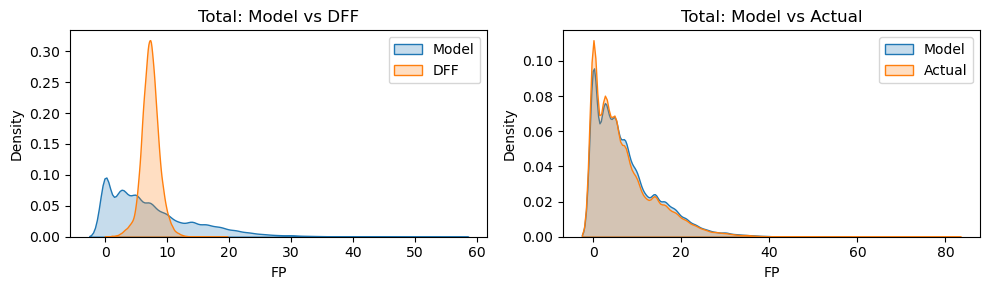

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))  # 1 row, 2 columns

# Left plot: Model vs DFF
sns.kdeplot(batters_with_dff['FP'], label='Model', shade=True, ax=axes[0])
sns.kdeplot(batters_with_dff['FP_DFF'], label='DFF', shade=True, ax=axes[0])
axes[0].legend()
axes[0].set_title("Total: Model vs DFF")

# Right plot: Model vs Actual
sns.kdeplot(batters_with_dff['FP'], label='Model', shade=True, ax=axes[1])
sns.kdeplot(batters_with_dff['fp'], label='Actual', shade=True, ax=axes[1])
axes[1].legend()
axes[1].set_title("Total: Model vs Actual")

plt.tight_layout()
plt.show()

##### Figure 2B. Batters over Time

In [46]:
# Step 1: Convert date column to datetime
batters_with_dff['date'] = pd.to_datetime(batters_with_dff['date'], format='%Y%m%d')

# Step 2: Create a Year-Month column
batters_with_dff['year_month'] = batters_with_dff['date'].dt.to_period('M')

# Step 3: Group by Year-Month and average the relevant columns
monthly_means = batters_with_dff.groupby('year_month')[
    ['FP', 'fp', 'FP_DFF']
].mean().reset_index()

# Step 4: Convert year_month back to datetime for plotting
monthly_means['year_month'] = monthly_means['year_month'].dt.to_timestamp()

Write to Excel

In [47]:
with pd.ExcelWriter(player_stat_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    monthly_means.to_excel(writer, sheet_name='BattersOverTime', index=False)

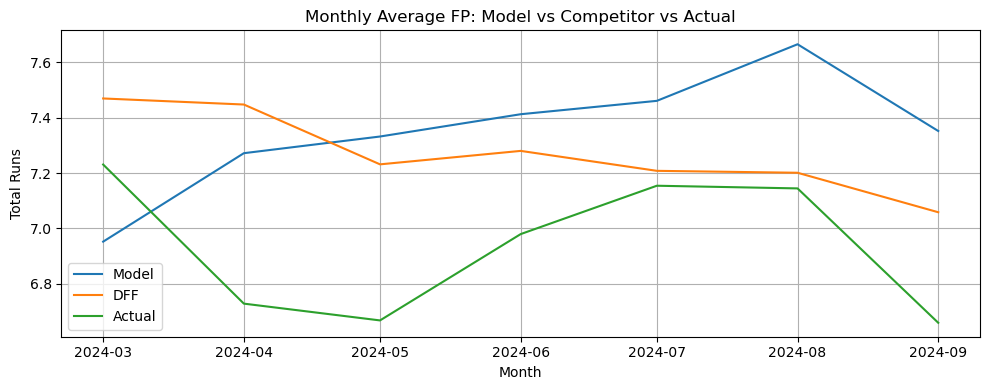

In [48]:
# Step 5: Plot
plt.figure(figsize=(10, 4))
plt.plot(monthly_means['year_month'], monthly_means['FP'], label='Model')
plt.plot(monthly_means['year_month'], monthly_means['FP_DFF'], label='DFF')
plt.plot(monthly_means['year_month'], monthly_means['fp'], label='Actual')

plt.title('Monthly Average FP: Model vs Competitor vs Actual')
plt.xlabel('Month')
plt.ylabel('Total Runs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

##### Figure 2C. Batters by Venue

In [49]:
batter_park_fp = batters_with_dff.query('battingSpotInstance == 1').groupby('venue_id')[['FP', 'FP_DFF', 'fp']].agg(['mean']).reset_index()
batter_park_fp.columns = ['VENUE_ID', 'FP', 'FP_DFF', 'fp']
batter_park_fp = pd.merge(batter_park_fp, venue_map_df[['id', 'name']], left_on='VENUE_ID', right_on='id', how='left')

batter_park_fp.rename(columns={'FP': 'Model',
                               'FP_DFF': 'DFF',
                               'fp': 'Actual'}, inplace=True)

batter_park_fp = batter_park_fp[['VENUE_ID', 'name', 'Model', 'DFF', 'Actual']]

batter_park_fp = batter_park_fp[batter_park_fp['VENUE_ID'].isin(team_map['VENUE_ID'].unique())]
batter_park_fp

,VENUE_ID,name,Model,DFF,Actual
0,1,Angel Stadium,7.047776,7.278443,7.388797
1,2,Oriole Park at Camden Yards,7.774244,7.344241,7.284751
2,3,Fenway Park,7.692097,7.643022,7.561969
3,4,Rate Field,7.408791,7.200301,6.977093
4,5,Progressive Field,7.558339,7.334675,7.116872
5,7,Kauffman Stadium,7.692308,7.474560,7.083686
6,10,Oakland Coliseum,8.104000,7.079642,6.752889
7,12,Tropicana Field,7.399508,7.079456,6.917966
8,14,Rogers Centre,7.858059,7.185744,7.057739
9,15,Chase Field,8.260204,7.498264,7.956633


Write to Excel

In [50]:
with pd.ExcelWriter(player_stat_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    batter_park_fp.to_excel(writer, sheet_name='BattersByVenue', index=False)

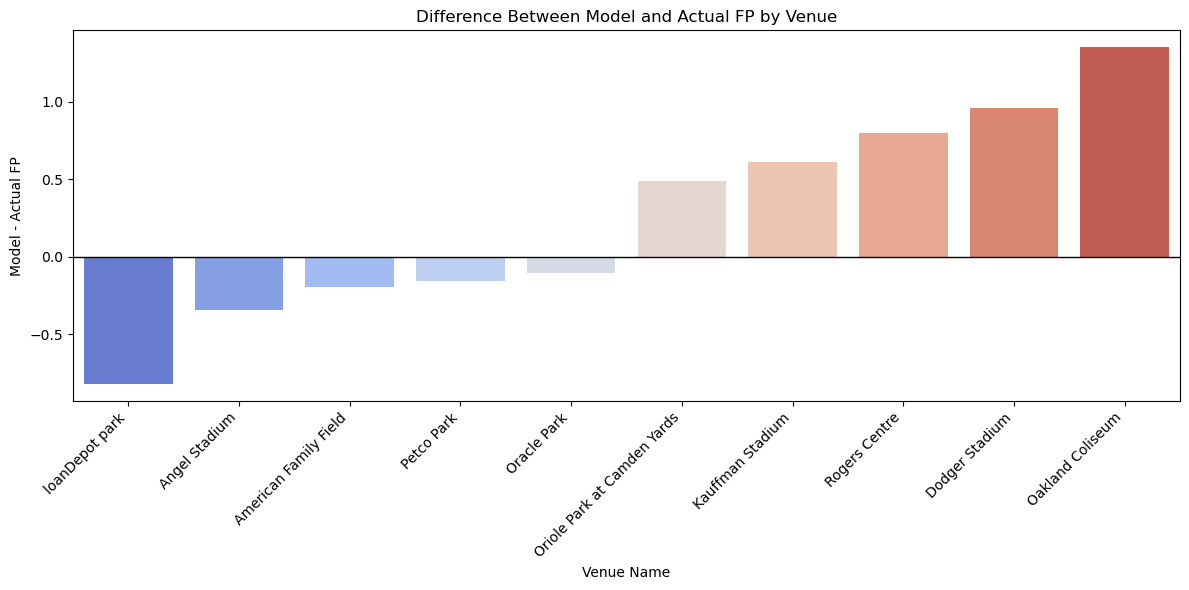

In [51]:
# Step 3: Compute the difference
batter_park_fp['Diff'] = batter_park_fp['Model'] - batter_park_fp['Actual']

# Step 4: Get top and bottom 5
sorted_batter_park_fp = batter_park_fp.sort_values('Diff')
top_bottom = pd.concat([sorted_batter_park_fp.head(5), sorted_batter_park_fp.tail(5)])

# Step 5: Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=top_bottom, x='name', y='Diff', palette='coolwarm')
plt.axhline(0, color='black', linewidth=1)
plt.title('Difference Between Model and Actual FP by Venue')
plt.ylabel('Model - Actual FP')
plt.xlabel('Venue Name')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

##### Pitchers

Merge DFF projections onto my projections

In [52]:
pitchers_with_dff = pitchers_merged_df.drop_duplicates(['fullName', 'date']).merge(dff_df, on=['fullName', 'date'], how='inner')

Create error and success measures

In [53]:
pitchers_with_dff['error_me'] = (pitchers_with_dff['fp'] - pitchers_with_dff['FP'])
pitchers_with_dff['error_dff'] = (pitchers_with_dff['fp'] - pitchers_with_dff['FP_DFF'])

pitchers_with_dff['error_me2'] = pitchers_with_dff['error_me'] ** 2
pitchers_with_dff['error_dff2'] = pitchers_with_dff['error_dff'] ** 2

pitchers_with_dff['beat_dff'] = (pitchers_with_dff['error_me2'] < pitchers_with_dff['error_dff2']).astype('int')

##### Figure 2D. Pitcher FP

In [54]:
pitcher_summary_stats = pitchers_with_dff.dropna().query('starter == 1')[['FP', 'FP_DFF', 'fp', 'error_me', 'error_dff', 'error_me2', 'error_dff2', 'beat_dff']].describe(percentiles=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
pitcher_summary_stats

,FP,FP_DFF,fp,error_me,error_dff,error_me2,error_dff2,beat_dff
count,4604.000000,4604.000000,4604.000000,4604.000000,4604.000000,4604.000000,4604.000000,4604.000000
mean,13.404320,13.842814,13.876151,0.471831,0.033338,209.067003,105.335772,0.358167
std,10.890805,3.509568,10.907758,14.453019,10.264382,287.770948,148.351097,0.479514
min,-19.750000,0.320000,-23.700000,-48.200000,-37.875000,0.000000,0.000016,0.000000
10%,-1.050000,9.680000,-0.185000,-18.300000,-13.334200,3.062500,1.857498,0.000000
20%,4.350000,11.169000,4.480000,-12.050000,-8.708800,13.543000,7.703956,0.000000
30%,7.900000,12.219400,7.900000,-7.300000,-5.170100,30.802500,16.753475,0.000000
40%,11.050000,13.067000,10.800000,-3.200000,-2.375800,57.912500,31.136400,0.000000
50%,13.700000,13.916000,13.850000,0.350000,0.347500,98.010000,50.055626,0.000000
60%,16.300000,14.748400,17.050000,4.150000,3.125000,150.062500,76.912900,0.000000


Write to Excel

In [55]:
with pd.ExcelWriter(player_stat_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    pitcher_summary_stats.to_excel(writer, sheet_name='PitcherFP', index=True)

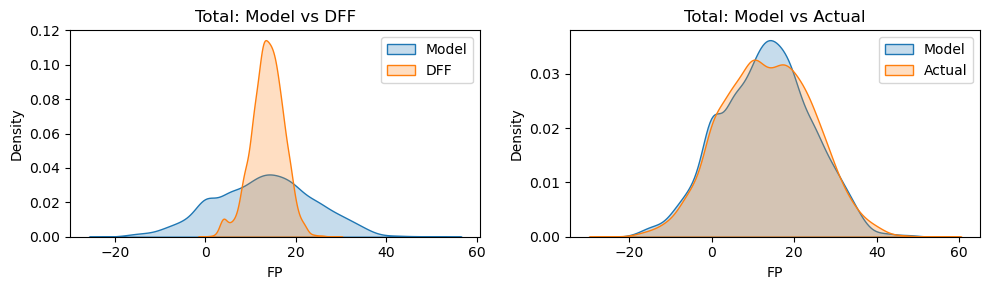

In [56]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))  # 1 row, 2 columns

# Left plot: Model vs DFF
sns.kdeplot(pitchers_with_dff['FP'], label='Model', shade=True, ax=axes[0])
sns.kdeplot(pitchers_with_dff['FP_DFF'], label='DFF', shade=True, ax=axes[0])
axes[0].legend()
axes[0].set_title("Total: Model vs DFF")

# Right plot: Model vs Actual
sns.kdeplot(pitchers_with_dff['FP'], label='Model', shade=True, ax=axes[1])
sns.kdeplot(pitchers_with_dff['fp'], label='Actual', shade=True, ax=axes[1])
axes[1].legend()
axes[1].set_title("Total: Model vs Actual")

plt.tight_layout()
plt.show()

##### Figure 2E. Pitchers over Time

In [57]:
# Step 1: Convert date column to datetime
pitchers_with_dff['date'] = pd.to_datetime(pitchers_with_dff['date'], format='%Y%m%d')

# Step 2: Create a Year-Month column
pitchers_with_dff['year_month'] = pitchers_with_dff['date'].dt.to_period('M')

# Step 3: Group by Year-Month and average the relevant columns
monthly_means = pitchers_with_dff.groupby('year_month')[
    ['FP', 'fp', 'FP_DFF']
].mean().reset_index()

# Step 4: Convert year_month back to datetime for plotting
monthly_means['year_month'] = monthly_means['year_month'].dt.to_timestamp()

Write to Excel

In [58]:
with pd.ExcelWriter(player_stat_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    monthly_means.to_excel(writer, sheet_name='PitchersOverTime', index=False)

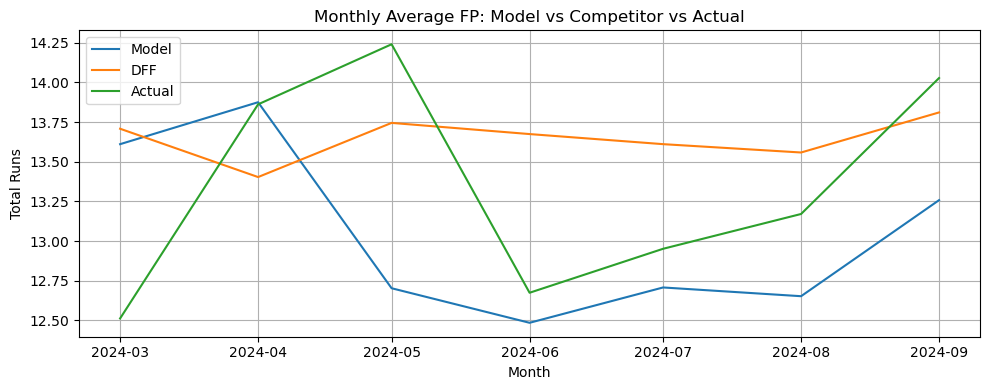

In [59]:
# Step 5: Plot
plt.figure(figsize=(10, 4))
plt.plot(monthly_means['year_month'], monthly_means['FP'], label='Model')
plt.plot(monthly_means['year_month'], monthly_means['FP_DFF'], label='DFF')
plt.plot(monthly_means['year_month'], monthly_means['fp'], label='Actual')

plt.title('Monthly Average FP: Model vs Competitor vs Actual')
plt.xlabel('Month')
plt.ylabel('Total Runs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

##### Figure 2F. Pitchers by Venue

In [60]:
pitcher_park_fp = pitchers_with_dff.query('starter == 1').groupby('venue_id')[['FP', 'FP_DFF', 'fp']].agg(['mean']).reset_index()
pitcher_park_fp.columns = ['VENUE_ID', 'FP', 'FP_DFF', 'fp']
pitcher_park_fp = pd.merge(pitcher_park_fp, venue_map_df[['id', 'name']], left_on='VENUE_ID', right_on='id', how='left')

pitcher_park_fp.rename(columns={'FP': 'Model',
                               'FP_DFF': 'DFF',
                               'fp': 'Actual'}, inplace=True)

pitcher_park_fp = pitcher_park_fp[['VENUE_ID', 'name', 'Model', 'DFF', 'Actual']]

pitcher_park_fp = pitcher_park_fp[pitcher_park_fp['VENUE_ID'].isin(team_map['VENUE_ID'].unique())]
    
pitcher_park_fp

,VENUE_ID,name,Model,DFF,Actual
0,1.0,Angel Stadium,14.658766,13.830708,13.738312
1,2.0,Oriole Park at Camden Yards,11.267434,14.275579,13.615789
2,3.0,Fenway Park,13.213312,13.723279,13.718506
3,4.0,Rate Field,13.582217,13.480736,13.979392
4,5.0,Progressive Field,11.059153,12.838953,12.016107
5,7.0,Kauffman Stadium,11.684375,13.630331,13.354688
6,10.0,Oakland Coliseum,12.403947,13.916368,14.261842
7,12.0,Tropicana Field,15.224051,14.225411,15.614557
8,14.0,Rogers Centre,12.153526,13.545673,13.610256
9,15.0,Chase Field,9.938924,12.996253,10.853165


Write to Excel

In [61]:
with pd.ExcelWriter(player_stat_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    pitcher_park_fp.to_excel(writer, sheet_name='PitchersByVenue', index=False)

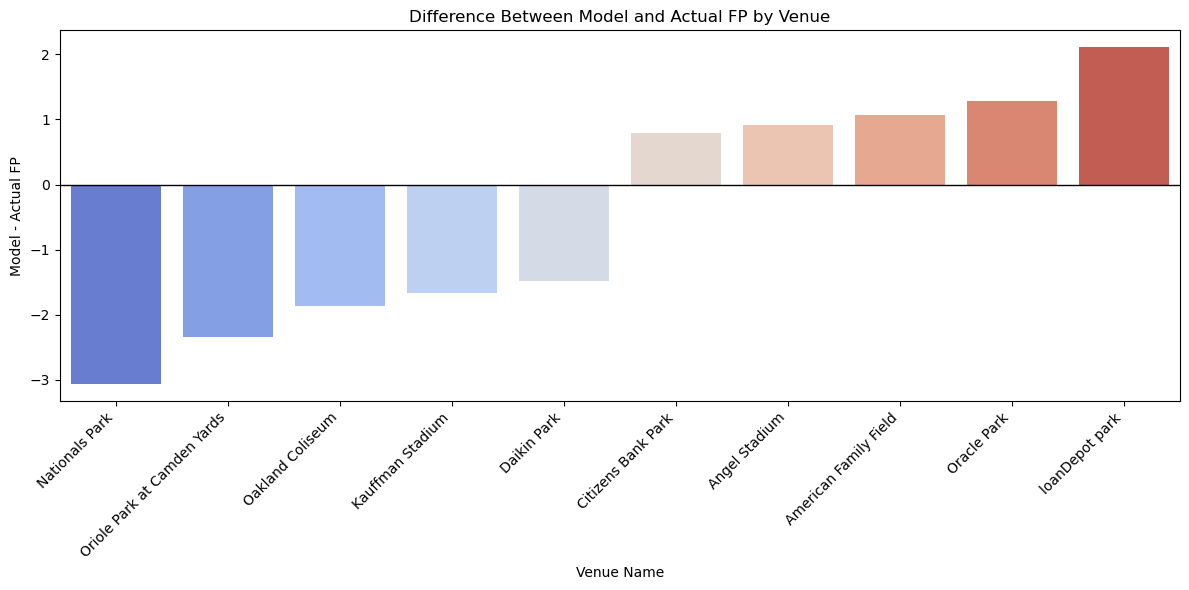

In [62]:
# Compute the difference
pitcher_park_fp['Diff'] = pitcher_park_fp['Model'] - pitcher_park_fp['Actual']

# Get top and bottom 5
pitcher_park_fp = pitcher_park_fp.sort_values('Diff')
top_bottom = pd.concat([pitcher_park_fp.head(5), pitcher_park_fp.tail(5)])

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=top_bottom, x='name', y='Diff', palette='coolwarm')
plt.axhline(0, color='black', linewidth=1)
plt.title('Difference Between Model and Actual FP by Venue')
plt.ylabel('Model - Actual FP')
plt.xlabel('Venue Name')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()